In [2]:
# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and submit it **and a `.txt` file** (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename1=07_Assignment_3.ipynb
local_scp_filepath1=~/git/iaml2017/${filename1}
filename2=assignment_3_predictions.txt
local_scp_filepath2=~/git/iaml2017/${filename2}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
scp -r ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
# rsync -rl ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
# rsync -rl ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Include all required imports and execute the cell below. It's typical to include package imports at the top of the file for clarity.

In [3]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

## Description of the dataset
In this assignment our goal is to recognize objects in images of realistic scenes. There are 19 different classes of object e.g. person, dog, cat, car, etc. The dataset derives from several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

We are going to detect whether images contain a person or not - a binary classification problem. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. Each column of the dataset (which is not an lable), refers to a 'visual word'. Each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 different visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). See the Appendix at the bottom of the notebook for more information. The image data is thus a $N \times 500$ dimensional matrix where `N` is the number of images.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) are a normalized count vector for each visual word. The last 19 attributes (`is_class`) are the labels - 1 means the class is present in the image. In most of the experiments (unless explicitly noted otherwise) you will only need the `is_person` attribute and the 500 dimensional feature vector. **Do not use the additional class indicator attributes as features** unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

**Important**: *Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 --- [1 mark] ==========
Create two Pandas DataFrame objects called `train_A` and `valid_A` by loading the datasets `train_images_partA.csv` and `valid_images_partA.csv`. Display the number of data points and attributes in each of the two datasets.

In [4]:
#Loading the datasets
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path, delimiter = ',')

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path, delimiter = ',')

#Printing out the number of data points and attributes
print('number of data points in train_A: {}, number of attributes in train_A: {}'
                                     .format(train_A.shape[0], train_A.shape[1]))

print('number of data points in valid_A: {}, number of attributes in valid_A: {}'
                                     .format(valid_A.shape[0], valid_A.shape[1]))

number of data points in train_A: 2093, number of attributes in train_A: 520
number of data points in valid_A: 1113, number of attributes in valid_A: 520


### ========== Question 1.2 --- [1 mark] ==========
Display and inspect the first 10 instances in the training dataset.

In [5]:
#Displaying first 10 instances in training dataset
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Inspecting the first 10 instances in the training dataset. 
train_A.head(10).describe()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.0,10.0,10.0,10.000000
mean,0.001323,0.001378,0.003231,0.000981,0.001586,0.002861,0.000965,0.003613,0.001945,0.002949,...,0.0,0.100000,0.100000,0.100000,0.0,0.400000,0.0,0.0,0.0,0.100000
std,0.000967,0.001930,0.002671,0.001001,0.001267,0.002186,0.000809,0.002370,0.001667,0.002110,...,0.0,0.316228,0.316228,0.316228,0.0,0.516398,0.0,0.0,0.0,0.316228
min,0.000000,0.000000,0.000000,0.000279,0.000372,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
25%,0.000600,0.000340,0.000619,0.000348,0.000719,0.001507,0.000340,0.002260,0.000093,0.001762,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
50%,0.001189,0.000474,0.003603,0.000605,0.001359,0.002135,0.000882,0.003219,0.002505,0.002645,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
75%,0.002065,0.002014,0.004682,0.001036,0.001646,0.004743,0.001386,0.004076,0.003397,0.004755,...,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000
max,0.002976,0.006324,0.007422,0.003516,0.003906,0.006114,0.002378,0.008185,0.003646,0.006138,...,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000


### ========== Question 1.3 --- [1 mark] ==========
Select the attributes (i.e. input features) for training our classifiers. These should be the visual word normalised counts `dim1, dim2, ..., dim500`. Create a list of the **names** of the attributes of interest. 

In [7]:
#Turn all of the attribute column labels into a list
attributes = list(train_A)[1:501]

In [8]:
print("To check I have all the attributes and only the attributes, I can confirm that my first attribute is " 
      + str(attributes[:1]) + "and my last attribute is " + str(attributes[499:]))

To check I have all the attributes and only the attributes, I can confirm that my first attribute is ['dim1']and my last attribute is ['dim500']


### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` in which to store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets. Display the dimensionalities (i.e shapes) of the 4 arrays. 

Check this carefully - you will be penalised in following questions if the data is not correct!

In [9]:
X_tr = train_A[attributes]
print("The shape of the array storing the training features is" +str(X_tr.shape))

The shape of the array storing the training features is(2093, 500)


In [10]:
X_val = valid_A[attributes]
print("The shape of the array storing the validation features is" +str(X_val.shape))

The shape of the array storing the validation features is(1113, 500)


In [11]:
y_tr = train_A["is_person"]
print("The shape of the array storing the training targets is" +str(y_tr.shape))

The shape of the array storing the training targets is(2093,)


In [12]:
y_val = valid_A["is_person"]
print("The shape of the array storing the validation targets is" +str(y_val.shape))

The shape of the array storing the validation targets is(1113,)


### ========== Question 1.5 --- [2 marks] ==========
Create a [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) for the training and validation targets. Create a single figure, and put the two plots inside the single figure. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

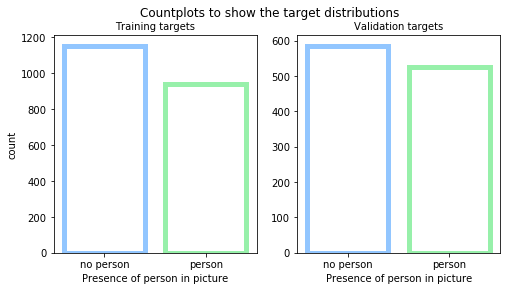

In [13]:
#Creating a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
plt.suptitle("Countplots to show the target distributions\n")

#Training set subplot
sns.countplot(y_tr, ax=ax1, facecolor=(0, 0, 0, 0), linewidth=5, edgecolor=sns.color_palette("pastel"))
ax1.set_title("Training targets", size=10)
ax1.set_xlabel("Presence of person in picture")
plt.setp(ax1, xticklabels=["no person", "person"])

#Validation set subplot
sns.countplot(y_val, ax=ax2, facecolor=(0, 0, 0, 0), linewidth=5, edgecolor=sns.color_palette("pastel"))
ax2.set_title("Validation targets", size=10)
ax2.set_xlabel("Presence of person in picture")
ax2.set_ylabel("")
plt.setp(ax2, xticklabels=["no person", "person"])

plt.show()

### ========== Question 1.6 --- [1 mark] ==========
We want to make a baseline classification accuracy to beat. Pick a baseline "dummy" classifier, describe in a sentence why you chose it, and report the accuracy it achieves on the validation set?

From the countplots in question 1.5, I can see that there is more often not a person in a picture than a person being in a picture (the mode for the training data, and coincidentally the validation data, is 'no person'), and therefore the most simple baseline I can think of is just to always classify a picture as having no person in it. This will be my dummy classifier. 

In [14]:
# Create a an array of '0's representing no person in picture that is as big as the matrix for the true values
# of is_person for the validation set. 
predictNoPerson = np.full(fill_value=0, shape=valid_A["is_person"].shape)

#Test the accuracy of the dummy classifier on the validation set
dummyAccuracyValidationSet = accuracy_score(y_val, predictNoPerson)

print("The accuracy of the dummy classifier I have chosen on the validation set is " 
                                                      + str(dummyAccuracyValidationSet))

The accuracy of the dummy classifier I have chosen on the validation set is 0.526504941599


### ========== Question 1.7 --- [3 marks] ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score on the training and validation sets and compare with the baseline. Comment on the results with 1-2 sentences. You may include any additional plot(s) if you wish to justify your explanation.

In [15]:
#Initialise logistic regression 
logistic = LogisticRegression(solver='lbfgs')

#Fit logistic regression classifier to training data
logistic.fit(X_tr, y_tr)

#Print accuracy scores
print("The accuracy score on the training set is " + str(logistic.score(X_tr, y_tr)))
print("The accuracy score on the validation set is " + str(logistic.score(X_val, y_val)))

The accuracy score on the training set is 0.55088389871
The accuracy score on the validation set is 0.526504941599


Immediately I notice something. The accuracy score for the validation set is exactly the same as the accuracy score I got using my dummy classifier in question 1.6. This means that the logistic regression classifier is also always predicted the outcome as 'no' person, at least for the validation set. Let me investigate further below. 


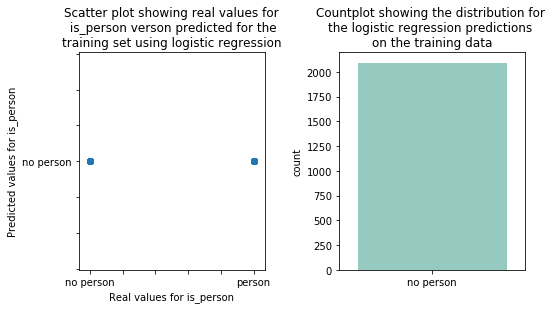

In [16]:
#Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
fig.subplots_adjust(wspace=0.4)

#Scatter plot of real is_person vs predicted for training data
ax1.scatter(y_tr, logistic.predict(X_tr))
ax1.set_title("Scatter plot showing real values for\n is_person verson predicted for the\n"
             +"training set using logistic regression")
ax1.set_xlabel("Real values for is_person")
ax1.set_ylabel("Predicted values for is_person")
plt.setp(ax1, xticklabels=["", "no person", "", "", "", "", "person"])
plt.setp(ax1, yticklabels=["", "", "", "", "no person"])

#Countplot of distribution of logistic regression predictions for training data
sns.countplot(logistic.predict(X_tr), ax=ax2, palette="Set3")
ax2.set_title("Countplot showing the distribution for \nthe logistic regression predictions \non the training data")
plt.setp(ax2, xticklabels=["no person"])
plt.show()

These two plots show me that, yes, the logistic regression classifier always predicts 'no person' for the training data, which is what my dummy classifier is doing.

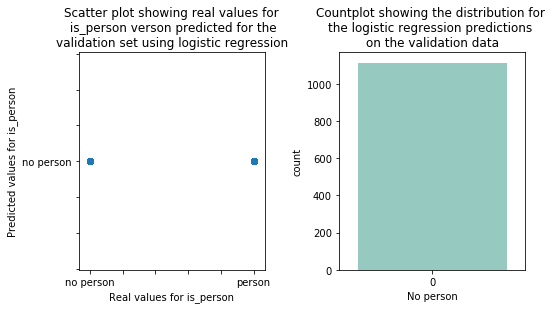

In [17]:
#Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
fig.subplots_adjust(wspace=0.4)

#Scatter plot of real is_person vs predicted for validation data
ax1.scatter(y_val, logistic.predict(X_val))
ax1.set_title("Scatter plot showing real values for\n is_person verson predicted for the\n"
             +"validation set using logistic regression")
ax1.set_xlabel("Real values for is_person")
ax1.set_ylabel("Predicted values for is_person")
plt.setp(ax1, xticklabels=["", "no person", "", "", "", "", "person"])
plt.setp(ax1, yticklabels=["", "", "", "", "no person"])

#Countplot of distribution of logistic regression predictions for validation data
sns.countplot(logistic.predict(X_val), ax=ax2, palette="Set3")
ax2.set_title("Countplot showing the distribution for \nthe logistic regression predictions \non the validation data")
ax2.set_xlabel("No person")
plt.show()

These plots show me that, as I expected, the logistic regression classifier is always predicting the result as 'no person' for any set. Since the logistic regression classifier is not better than my dummy baseline classifier, I do not think that it is a good classifier at all. I get the same results using my basline classifier so it would be illogical to use logistic regression which is more complicated when it does not increase the accuracy at all. 

### ========== Question 1.8 --- [1 mark] ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [18]:
print("Means of the first 5 features in the training set:")
np.mean(X_tr, axis=0)[:5]

Means of the first 5 features in the training set:


dim1    0.001751
dim2    0.000756
dim3    0.004317
dim4    0.001853
dim5    0.002272
dtype: float64

In [19]:
print("Standard deviations of the first 5 features in the training set:")
np.std(X_tr, axis=0)[:5]

Standard deviations of the first 5 features in the training set:


dim1    0.001193
dim2    0.001406
dim3    0.003693
dim4    0.001340
dim5    0.001598
dtype: float64

### ========== Question 1.9 --- [3 marks] ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers a [class](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) for feature standardisation. Instansiate a StandardScaler object and fit it using the **training features**. Use this fitted object to transform both your training and validation features to have a standard scale. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. Why didn't we use the validation set to standardise the data?

**IMPORTANT: You should use the transformed data for the rest of this part.**

In [20]:
scaled = StandardScaler()
scaled.fit(X_tr)
X_tr=(scaled.transform(X_tr))
X_val=(scaled.transform(X_val))

In [21]:
print("The means for the first 5 attributes for the transformed training set are:\n" +str(np.mean(X_tr, axis=0)[0:5]))

print("\n The standard deviations for the first 5 attributes for the transformed training set are:\n" +
      str(np.std(X_tr, axis=0)[0:5]))

print("\n\nThe means for the first 5 attributes for the transformed validation set are:\n" +
      str(np.mean(X_val, axis=0)[0:5]))

print("\nThe standard deviations for the first 5 attributes for the transformed validation set are:\n" +
      str(np.std(X_val, axis=0)[0:5]))

The means for the first 5 attributes for the transformed training set are:
[ -3.39485301e-17  -2.20665446e-17   2.44429417e-16   1.42583827e-16
  -5.77125012e-17]

 The standard deviations for the first 5 attributes for the transformed training set are:
[ 1.  1.  1.  1.  1.]


The means for the first 5 attributes for the transformed validation set are:
[-0.00550612 -0.0382933   0.10915098  0.09369314  0.03057844]

The standard deviations for the first 5 attributes for the transformed validation set are:
[ 1.01310886  0.96981949  1.0492285   1.05684479  0.97471336]


My results are pretty close to what I expected. I expected my training set mean to be around 0, which it was, and standard deviation to be 1, which it is exactly, for at least the first five features. I would also expect my validation set mean to be around 0 and standard deviation to be around 1, but not quite as close to these numbers as the training set (this is also what I observed for the first five features as shown above), as I fitted using the training set not the validation set. 

We didn't use the validation set to standardise the data because we want to train our model on the training data (not the validation data - we only use this to tweak out parameters for our model), so we need to standardise the training data in order to train a model on it.

### ========== Question 1.10 --- [3 marks] ==========
By using the transformed input data, train a new `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy on both the training and validation sets.

Comment on how your model compares to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [22]:
#Initialise logistic regression 
logistic2 = LogisticRegression(solver='lbfgs')

#Fit logistic regression classifier to training data
logistic2.fit(X_tr, y_tr)

#Print accuracy scores
print("The accuracy score on the training set is " + str(logistic2.score(X_tr, y_tr)))
print("The accuracy score on the validation set is " + str(logistic2.score(X_val, y_val)))

The accuracy score on the training set is 0.810797897754
The accuracy score on the validation set is 0.643306379155


In question 1.6, using the dummy classifier of always predicting 'no person', I got an accuracy of 0.526504941599 on the validation set. Using my logistic regression classifier in this question, I get a better accuracy of ~0.650 on the validation set and ~0.81 on the training set. This is because my classifier is not just always predicting 'no person', but instead correctly classifies more images than the dummy classifier does. 

The countplots below show that the logistic regression classifier classifies about the right amount of 'no person' and 'person' images, however it does not necessarily classify them correctly (it may classify some with 'no person' as 'person', but overall manages to end up with a countplot showing the right distribution anyway), so this plot is not that helpful to try and see the accuracy. I will explain further below. 

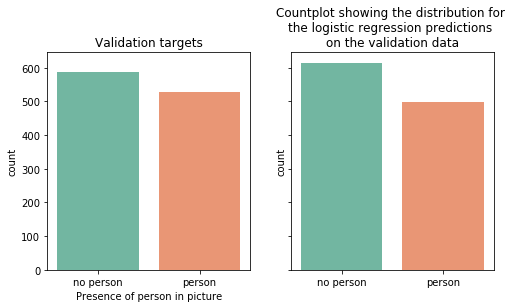

In [23]:
#Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(8,4))
fig.subplots_adjust(hspace=1.4)

#Training set subplot
sns.countplot(y_val, ax=ax1, palette="Set2")
ax1.set_title("Validation targets")
ax1.set_xlabel("Presence of person in picture")
plt.setp(ax1, xticklabels=["no person", "person"])


#Countplot of distribution of logistic regression predictions for training data
sns.countplot(logistic2.predict(X_val), ax=ax2, palette="Set2")
ax2.set_title("Countplot showing the distribution for \nthe logistic regression predictions \non the validation data")
plt.setp(ax2, xticklabels=["no person", "person"])

plt.show()

The stripplots below show that generally images with no person are classified as such (solid colour in the bottom left hand of the plot), but occasionally they are classified as having a person (less solid colour in the top left area of the plot), and vice versa for images with a person. 

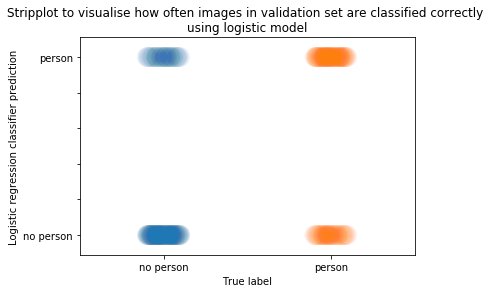

In [24]:
#Stripplot visualising correctly and incorrectly classified images for validation set using logistic model
ax0 = sns.stripplot(y_val, logistic2.predict(X_val), jitter=True, size=20, alpha=0.01)
ax0.set_xlabel("True label")
ax0.set_ylabel("Logistic regression classifier prediction")
ax0.set_title("Stripplot to visualise how often images in validation set are classified correctly \nusing logistic model")
plt.setp(ax0, xticklabels=["no person", "person"])
plt.setp(ax0, yticklabels=["", "no person", "", "", "", "", "person"])

plt.show()

The stripplot below shows that the dummy classifier only ever classifies images as 'no person' and that the amount of images that really have a person are often classified as no person (seen by the solid colour of orange). 

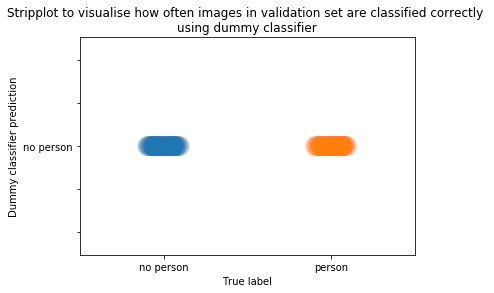

In [25]:
#Stripplot visualising correctly and incorrectly classified images for validation set using dummy model
ax2 = sns.stripplot(y_val, predictNoPerson, jitter=True, size=20, alpha=0.01)
ax2.set_xlabel("True label")
ax2.set_ylabel("Dummy classifier prediction")
ax2.set_title("Stripplot to visualise how often images in validation set are classified correctly \nusing dummy classifier")
plt.setp(ax2, xticklabels=["no person", "person"])
plt.setp(ax2, yticklabels=["", "", "", "no person"])
plt.show()

The accuracy scores show that the logistic classifier performs better than the baseline in terms of accuracy, and the plots help to explain why.

### ========== Question 1.11 --- [1 mark] ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes in the weight vector. This can help us prevent overfitting but, if set too high, could lead us to underfit too.

Create a 3-fold cross-validation object. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples for each fold.

In [26]:
#Make a 3-cross-validation object
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

#Print training and validation indices for auto_numeric dataset
def noSamplesinFolds(data):
    i=0
    for train_index, validation_index in kfold.split(data):
        print("\n\nThe number of validation (test) samples in fold {} is: {}\n". format(i+1, len(validation_index)))
        i=i+1

noSamplesinFolds(X_tr)



The number of validation (test) samples in fold 1 is: 698



The number of validation (test) samples in fold 2 is: 698



The number of validation (test) samples in fold 3 is: 697



### ========== Question 1.12 --- [3 marks] ========== 
Using the cross-validation iterator from the previous question, perform a search for the best value for `C`. 

We are going to loop over each CV fold, and each value of `C`. The values of `C` to search should be 20 equally-spaced values **in log space** ranging from `1e-5` to `1e5` *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters (except for `C` obviously!).

*(hint: you could use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [27]:
#Create C values
C = np.logspace(-5, 5, 20, base=10.0) 

#Create zero matrix with correct dimensions
Matrix = [[0 for x in range(len(C))] for y in range(kfold.n_splits)] 

#i will be a counter for the folds
i=0

#Use loops to train a new logistic regression for each C value within each fold and save its accuracy in 
#appropriate place in Matrix
for train_index, validation_index in kfold.split(X_tr):
    for cindex, cvalue in enumerate(C):
        logistic3 = LogisticRegression(solver='lbfgs', C=cvalue)
        logistic3.fit(X_tr[train_index], y_tr[train_index])
        Matrix[i][cindex] = accuracy_score(y_tr[validation_index], logistic3.predict(X_tr[validation_index]))
    i=i+1 

In [28]:
#Have a look at Matrix to ensure it looks reasonable
Matrix

[[0.57306590257879653,
  0.62893982808022919,
  0.66762177650429799,
  0.67191977077363896,
  0.68767908309455583,
  0.69627507163323787,
  0.67478510028653294,
  0.67048710601719197,
  0.65329512893982811,
  0.65902578796561606,
  0.65902578796561606,
  0.65329512893982811,
  0.64899713467048714,
  0.64613180515759316,
  0.64613180515759316,
  0.64899713467048714,
  0.64613180515759316,
  0.64613180515759316,
  0.64899713467048714,
  0.64899713467048714],
 [0.54584527220630374,
  0.63180515759312317,
  0.69484240687679089,
  0.71919770773638969,
  0.72922636103151861,
  0.73495702005730656,
  0.70200573065902583,
  0.67478510028653294,
  0.6547277936962751,
  0.63610315186246413,
  0.63180515759312317,
  0.63323782234957016,
  0.62607449856733521,
  0.6275071633237822,
  0.6275071633237822,
  0.62607449856733521,
  0.62607449856733521,
  0.62607449856733521,
  0.6275071633237822,
  0.62607449856733521],
 [0.54806312769010046,
  0.63558106169296991,
  0.642754662840746,
  0.65566714490

### ========== Question 1.13 --- [1 mark] ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

In [29]:
meanAccuracy = np.mean(Matrix, axis=0)

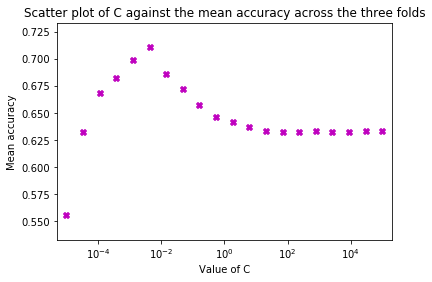

In [30]:
#Plot of C against mean accuracy ac
plt.scatter(C, meanAccuracy, marker="X", color='m')
plt.xscale('log')
plt.xlim([0.000005, 200000])
plt.title('Scatter plot of C against the mean accuracy across the three folds')
plt.xlabel('Value of C')
plt.ylabel('Mean accuracy')
plt.show()

### ========== Question 1.14 --- [2 marks] ==========
Display the optimal value for the regularisation parameter `C` determined by the search results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [31]:
#get the index of the maximum mean accuracy, then use this to find corresponding C value
maxIndexC1 = np.argmax(meanAccuracy)
optimalC = C[maxIndexC1]

#Train new logistic regression using optimal C value
logistic4 = LogisticRegression(solver='lbfgs', C=C[np.argmax(meanAccuracy)])
logistic4.fit(X_tr, y_tr)


print("The optimal value of C determined by question 1.13 is " + str(optimalC) +
     " and the accuracy score using a logistic regression with this C value is " + 
      str(accuracy_score(y_val, logistic4.predict(X_val)) ))

The optimal value of C determined by question 1.13 is 0.00428133239872 and the accuracy score using a logistic regression with this C value is 0.696316262354


### ========== Question 1.15 --- [1 mark] ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Check your results are consistent with those from Question 1.14!

In [32]:
logisticCV1 = LogisticRegressionCV(Cs=C, cv=kfold, solver='lbfgs')
logisticCV1.fit(X_tr, y_tr)

print("The LogisticRegressionCV model chose the best value of C as " + str(logisticCV1.C_) +
      ". The classification accuracy on the validation set is " + str(logisticCV1.score(X_val, y_val))
      + ", which matches my values in 1.14.")

The LogisticRegressionCV model chose the best value of C as [ 0.00428133]. The classification accuracy on the validation set is 0.696316262354, which matches my values in 1.14.


### ========== Question 1.16 --- [1 mark] ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 42 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [33]:
randomForest1 = RandomForestClassifier(n_estimators=500, random_state=42)
randomForest1.fit(X_tr, y_tr)
RF1trainingScore = randomForest1.score(X_tr, y_tr)
RF1valScore = randomForest1.score(X_val, y_val)

In [34]:
print("accuracy of the random forest classifier on the training set: {} \naccuracy on the validation set: {}".format(RF1trainingScore, RF1valScore))  

accuracy of the random forest classifier on the training set: 1.0 
accuracy on the validation set: 0.692722371968


### ========== Question 1.17 --- [2 marks] ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

The accuracy on the training set is almost perfect (it has been rounded to 1.0) and then the accuracy on the validation set is a fair bit lower at around 0.693. This is a fairly big difference, but it isn't that surprising. Random forest classifiers are supposed to try and reduce overfitting, but if n_estimators (number of trees) is too low, or max_depth is  not specified, then this can lead to overfitting. As I can see below, when I introduce a max_depth and prune, then there is no longer such a large discrepency and the accuracy on the training set is not overfit as it is no longer a perfect 1.0.


In [35]:
randomForest1 = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=4)
randomForest1.fit(X_tr, y_tr)
RF1trainingScore = randomForest1.score(X_tr, y_tr)
RF1valScore = randomForest1.score(X_val, y_val)
print("accuracy of the random forest classifier on the training set: {} \naccuracy on the validation set: {}".format(RF1trainingScore, RF1valScore))  

accuracy of the random forest classifier on the training set: 0.767319636885 
accuracy on the validation set: 0.672955974843


### ========== Question 1.18 --- [2 marks] ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [36]:
#Get the feature importances (a proportion representing how important each feature is)
importances = randomForest1.feature_importances_

#Get the indices of the feature importances from most important to least 
descendingImportanceIndices = np.argsort(-importances)

#change attributes to numpy array so we can index it using another list
attributes = np.array(attributes)

print("The 50 most important features in descending order of importance are:\n\n" +
      str(attributes[descendingImportanceIndices][:50]))

The 50 most important features in descending order of importance are:

['dim21' 'dim360' 'dim76' 'dim461' 'dim4' 'dim51' 'dim479' 'dim283'
 'dim263' 'dim343' 'dim356' 'dim74' 'dim348' 'dim398' 'dim214' 'dim485'
 'dim217' 'dim222' 'dim347' 'dim134' 'dim254' 'dim274' 'dim90' 'dim312'
 'dim442' 'dim326' 'dim423' 'dim92' 'dim154' 'dim330' 'dim427' 'dim288'
 'dim322' 'dim96' 'dim353' 'dim440' 'dim77' 'dim153' 'dim54' 'dim271'
 'dim329' 'dim48' 'dim483' 'dim73' 'dim289' 'dim500' 'dim25' 'dim430'
 'dim315' 'dim17']


### ========== Question 1.19 --- [3 marks] ==========
Next, we would like to test the performance of support vector machines. Train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [37]:
#Train three models

#N.B. could also have used LinearSVC as this is supposed to be more stable, but in fact I got worse scores so decided to 
#stick with kernel='linear
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_tr, y_tr)

svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_tr, y_tr)

svc_poly = SVC(kernel='poly')
svc_poly.fit(X_tr, y_tr)

print("Classification accuracies:")
print("SVC with linear kernal on training data:" + str(svc_linear.score(X_tr, y_tr)))
print("SVC with linear kernal on validation data:" + str(svc_linear.score(X_val, y_val)))

print("\n\nSVC with rbf kernal on training data:" + str(svc_rbf.score(X_tr, y_tr)))
print("SVC with rbf kernal on validation data:" + str(svc_rbf.score(X_val, y_val)))

print("\n\nSVC with poly kernal on training data:" + str(svc_poly.score(X_tr, y_tr)))
print("SVC with poly kernal on validation data:" + str(svc_poly.score(X_val, y_val)))

Classification accuracies:
SVC with linear kernal on training data:0.842331581462
SVC with linear kernal on validation data:0.638814016173


SVC with rbf kernal on training data:0.910654562828
SVC with rbf kernal on validation data:0.729559748428


SVC with poly kernal on training data:0.990922121357
SVC with poly kernal on validation data:0.701707097934


### ========== Question 1.20 --- [3 marks] ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the shape of the boundaries and what this means for classification accuracy in 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [38]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

In [39]:
#Select the two training feature columns 
twoDtrainingColumns = [20,75]


#Fit the 3 models
svc_linear2 = SVC(kernel='linear')
svc_linear2.fit(X_tr[:, twoDtrainingColumns], y_tr)

svc_rbf2 = SVC(kernel='rbf')
svc_rbf2.fit(X_tr[:, twoDtrainingColumns], y_tr)

svc_poly2 = SVC(kernel='poly')
svc_poly2.fit(X_tr[:, twoDtrainingColumns], y_tr)


#Put the three models into a list so it can be passed into the function given in the question
classifiersList = [svc_linear2, svc_rbf2, svc_poly2]


In [40]:
#For my own understanding, see what degree of polynomial the poly kernel classifier 
#selected to choose boundaries 
print("The SVC classifier with the polynomial kernal chose the decision boundary for the 2D " +
      "data as a function with degree " + str(svc_poly2.degree))

The SVC classifier with the polynomial kernal chose the decision boundary for the 2D data as a function with degree 3


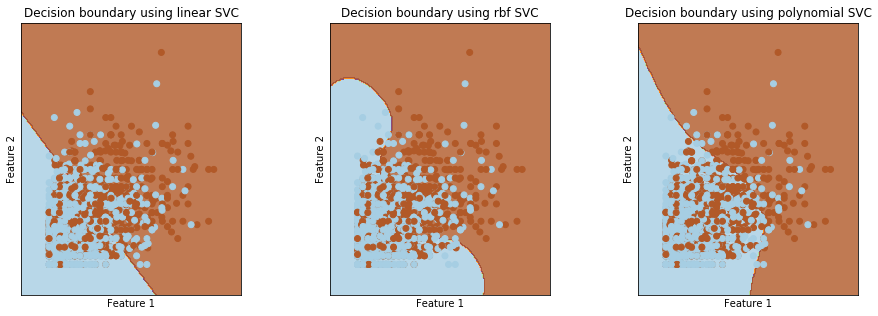

In [41]:
#Plot decision boundaries
show_svc_decision_boundaries(classifiersList, X_tr[:, twoDtrainingColumns], 
                             title=['Decision boundary using linear SVC', 
                                    'Decision boundary using rbf SVC', 
                                    'Decision boundary using polynomial SVC'])

The linear decision boundary of the linear SVC is, of course, a line. This is not very good for classification accuracy here because as we can see, the data cannot naturally be separated into classes by a straight line, so even with a best fitted line, many points will still be incorrectly classified. 

The decision boundaries using rbf and polynomial kernels are both more curved around the data. The rbf kernel's is almost like little hills and does a fairly good job of separating the data and so has a good accuracy. The decision boundary with the polynomial SVC is a cubic graph in 2D. It separates the data well for the training set. From looking at it visually, the rbf kernel classifier seems to be very slightly overfitting, so the training accuracy will be good, and most likely slightly better than the classifier with the rbf kernel, but when it comes to the validation set, the accuracy may not be as good as the classifier using the polynomial kernel. 

### ========== Question 1.21 --- [5 marks] ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [42]:
#Define C range
C2 = np.logspace(-2, 3, 10) 

#Create empty list where I will store the accuracies of the classifiers
crossValAccuracies = []

#For each C value, create a new rbf kernel SVC classifier and append the three accuracies ( one for each fold)
#to the above list
for cindex, cvalue in enumerate(C2):
    svc_rbf3 = SVC(kernel='rbf', gamma='auto', C=cvalue)
    crossValAccuracies.append(cross_val_score(svc_rbf3, X_tr, y_tr, cv=kfold))

In [43]:
#Take a look at the list to see that it looks reasonable
crossValAccuracies

[array([ 0.56017192,  0.54584527,  0.54662841]),
 array([ 0.58309456,  0.54584527,  0.54806313]),
 array([ 0.67191977,  0.69770774,  0.68579627]),
 array([ 0.70200573,  0.73782235,  0.69727403]),
 array([ 0.71346705,  0.73925501,  0.69296987]),
 array([ 0.70916905,  0.71346705,  0.68292683]),
 array([ 0.70916905,  0.71346705,  0.68292683]),
 array([ 0.70916905,  0.71346705,  0.68292683]),
 array([ 0.70916905,  0.71346705,  0.68292683]),
 array([ 0.70916905,  0.71346705,  0.68292683])]

In [44]:
meanCrossValAccuracies = np.mean(crossValAccuracies, axis=1)
meanCrossValAccuracies

array([ 0.55088187,  0.55900099,  0.68514126,  0.71236737,  0.71523064,
        0.70185431,  0.70185431,  0.70185431,  0.70185431,  0.70185431])

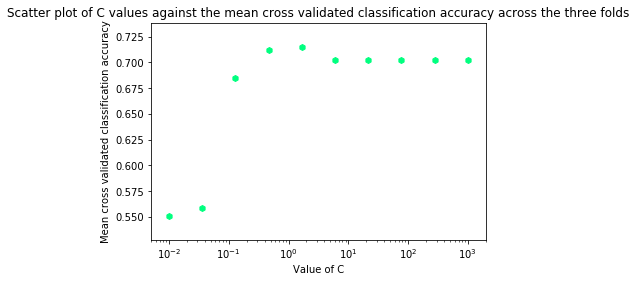

In [45]:
#Plot C against mean cross val accuracy
plt.scatter(C2, meanCrossValAccuracies, marker="h", color='springgreen')
plt.xscale('log')
plt.xlim([0.005, 2000])
plt.title('Scatter plot of C values against the mean cross validated classification accuracy across the three folds')
plt.xlabel('Value of C')
plt.ylabel('Mean cross validated classification accuracy')
plt.show()

In [46]:
#Find max cross val accuracy and corresponding C
maxIndexC = np.argmax(meanCrossValAccuracies)
highestMeanAccuracy = meanCrossValAccuracies[maxIndexC]
CValueWithHighestMeanAccuracy = C2[maxIndexC]

print("The highest mean cross validated classification accuracy was " + str(highestMeanAccuracy))
print("\nThe value of C with this accuracy was " + str(CValueWithHighestMeanAccuracy))

The highest mean cross validated classification accuracy was 0.715230644637

The value of C with this accuracy was 1.6681005372


In [47]:
#Train new classifier using optimal C
svc_rbf9 = SVC(kernel='rbf', C=CValueWithHighestMeanAccuracy).fit(X_tr, y_tr) 
print("After training a classifier using the optimal C,")
print("\n the accuracy on the training set is " + str(svc_rbf9.score(X_tr, y_tr)))
print("\n and the accuracy on the validation set is " + str(svc_rbf9.score(X_val, y_val)))

After training a classifier using the optimal C,

 the accuracy on the training set is 0.974677496417

 and the accuracy on the validation set is 0.727762803235


### ========== Question 1.22 --- [5 marks] ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [48]:
#Create gamma range
Gamma = np.logspace(-5, 0, 10) 

#Create empty list to store accuracies in
crossValAccuraciesGamma = []

#For each gamma value, create a new rbf kernel SVC classifier and append the three accuracies ( one for each fold)
#to the above list
for gindex, gvalue in enumerate(Gamma):
    svc_rbf3 = SVC(kernel='rbf', gamma=gvalue, C=1.0)
    crossValAccuraciesGamma.append(cross_val_score(svc_rbf3, X_tr, y_tr, cv=kfold))

KeyboardInterrupt: 

In [ ]:
meanCrossValAccuraciesGamma = np.mean(crossValAccuraciesGamma, axis=1)

In [ ]:
#Plot gamma against mean cross val accuracy
plt.scatter(Gamma, meanCrossValAccuraciesGamma, marker="*", color='tomato')
plt.xscale('log')
plt.xlim([0.000005, 2])
plt.title('Scatter plot of gamma values against the mean cross validated classification accuracy across the three folds')
plt.xlabel('Value of gamma')
plt.ylabel('Mean cross validated classification accuracy')
plt.show()

In [ ]:
#Find max cross val accuracy and corresponding gamma
maxIndex = np.argmax(meanCrossValAccuraciesGamma)
highestMeanAccuracyGamma = meanCrossValAccuraciesGamma[maxIndex]
gammaValueWithHighestMeanAccuracy = Gamma[maxIndex]

print("The highest mean cross validated classification accuracy was " + str(highestMeanAccuracyGamma))
print("\nThe value of gamma with this accuracy was " + str(gammaValueWithHighestMeanAccuracy))

In [ ]:
#Train new classifier using optimal gamma
svc_rbf8 = SVC(kernel='rbf', gamma = gammaValueWithHighestMeanAccuracy).fit(X_tr, y_tr) 
print("After training a classifier using the optimal degree of polynomial,")
print("\n the accuracy on the training set is " + str(svc_rbf8.score(X_tr, y_tr)))
print("\n and the accuracy on the validation set is " + str(svc_rbf8.score(X_val, y_val)))

### ========== Question 1.23 --- [7 marks] ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [ ]:
#Create C and gamma ranges
C3 = np.logspace(-2, 1, 4)
Gamma2 = np.logspace(-4, -1, 4)

#create empty 4x4 matrix
Matrix2 = [[0 for x in range(len(C3))] for y in range(len(Gamma2))] 

In [ ]:
#for each C-gamma pair, initialise new classifier and store calcuated mean cross val accuracy 
#on training data in Matrix2
for gindex, gvalue in enumerate(Gamma2):
    for cindex, cvalue in enumerate(C3):
        svc_rbf3 = SVC(kernel='rbf', gamma=gvalue, C=cvalue)
        Matrix2[gindex][cindex] = np.mean(cross_val_score(svc_rbf3, X_tr, y_tr, cv=kfold))

In [ ]:
Matrix2

In [ ]:
#heatmap to visualise Matrix2
ax = sns.heatmap(Matrix2, annot=True, xticklabels=C3, yticklabels=Gamma2)
ax.set_xlabel('C value')
ax.set_ylabel('Gamma value')
ax.set_title('Heatmap to visualise the mean cross-validated\n classification accuracy for all C-gamma pairs')
plt.show()

In [ ]:
#Get coordinates('row' then 'column' of Matrix 2) of the maximum value in Matrix2. We need a function to do
#this because looking at it by hand we can't tell as there are two max values at 0.71. 
maxPosition = np.unravel_index(np.argmax(Matrix2), [4,4])
maxPosition

In [ ]:
#Check that maxPosition does in fact give us one of the maximum accuracy values that we expect
Matrix2[maxPosition[0]][maxPosition[1]]

In [ ]:
#Locate C and gamma values that give us the maximum accuracy together  could get max accuracy? 
bestGammaPair = Gamma2[maxPosition[0]]
bestCPair = C3[maxPosition[1]]

print("The best performing configuration is when gamma is " + str(bestGammaPair) +
     " and C is " +str(bestCPair))

In [ ]:
svc_rbf4 = SVC(kernel='rbf', gamma=bestGammaPair, C=bestCPair).fit(X_tr, y_tr) 
print("After training a classifier using the optimal Gamma-C pair,")
print("\n the accuracy on the training set is " + str(svc_rbf4.score(X_tr, y_tr)))
print("\n and the accuracy on the validation set is " + str(svc_rbf4.score(X_val, y_val)))

### ========== Question 1.24 --- [3 marks] ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

My classification accuracies in question 1.23 was 0.721473495058 and in the previous two questions was 0.727762803235 and 0.726864330638. This means that when getting the optimal C, gamma pair, my accuracy actually decreased. This is because for the afore 2 questions, we took larger ranges of logspaces with more steps, so we had more chances to find more optimal values and we did, whereas in the last question we only took 4 steps and had a 4x4 grid of C, gamma pairs. 

If we had the afore two larger range log spaces with more points and used them in the same way we did in the last question, i.e. make a 10 by 10 grid of C, gamma pairs, then this would probably improve the classifier as we would probably discover a more optimal C, gamma pair. 

The problem with this is it would be very computationally expensive and slow.

### ========== Question 1.25 --- [5 marks] ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [ ]:
#Define degree range
degree1 = np.arange(1,8)

#Create empty list to store accuracies in
crossValAccuraciesDegree = []

#For each degree value, create a new rbf kernel SVC classifier and append the three accuracies ( one for 
#each fold) to the above list
for dindex, dvalue in enumerate(degree1):
    svc_rbf5 = SVC(kernel='poly', degree=dvalue)
    crossValAccuraciesDegree.append(cross_val_score(svc_rbf5, X_tr, y_tr, cv=kfold))

In [ ]:
meanCrossValAccuraciesDegree = np.mean(crossValAccuraciesDegree, axis=1)

In [ ]:
#Plot of degree of polynomial against mean cross val accuracy
plt.scatter(degree1, meanCrossValAccuraciesDegree, marker="+", color='red')
plt.title('Scatter plot of degree values against the mean cross validated classification accuracy across the three folds')
plt.xlabel('Degree of polynomial')
plt.ylabel('Mean cross validated classification accuracy')
plt.show()

In [ ]:
#Find max cross val accuracy and corresponding degree
maxIndexDegree = np.argmax(meanCrossValAccuraciesDegree)
highestMeanAccuracyDegree = meanCrossValAccuraciesDegree[maxIndexDegree]
DegreeValueWithHighestMeanAccuracy = degree1[np.argmax(meanCrossValAccuraciesDegree)]

print("The highest mean cross validated classification accuracy was " + str(highestMeanAccuracyDegree))
print("\nThe value of degree with this accuracy was " + str(DegreeValueWithHighestMeanAccuracy))

In [ ]:
#Train new classifier using optimal degree of polynomial
svc_poly7 = SVC(kernel='poly', degree=DegreeValueWithHighestMeanAccuracy).fit(X_tr, y_tr) 
print("After training a classifier using the optimal degree of polynomial,")
print("\n the accuracy on the training set is " + str(svc_poly7.score(X_tr, y_tr)))
print("\n and the accuracy on the validation set is " + str(svc_poly7.score(X_val, y_val)))

### ========== Question 1.26 --- [4 marks] ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

Hold-out:

Advantage: Less computationally expensive and takes less time.

Disadvantage: It only produces one training and validation set, so if the validation set doesn't contain values which reflect the true or training data well, then we can get large accuracy errors. This is especially evident in smaller training datasets.

Cross-validation:

Advantage: Cross validation makes, multiple times, its own training and target sets from the training set we give it. Therefore the average accuracy score across the folds will probably be a more trustworthy accuracy score.

Disadvantage: It is computationally expensive and slow, especially with a large number of folds.

In practise, I would trust cross-validation more because even though it is slower, its results should be more accurate/trustworthy.

### ========== Question 1.27 --- [6 marks] ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [ ]:
#Loading the datasets
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path, delimiter = ',')

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path, delimiter = ',')

In [ ]:
#Redefining training and validation features and targets
y_tr = train_A["is_person"]

X_tr = pd.DataFrame(train_A.drop(["is_person", "imgId"], axis=1))

y_val = valid_A["is_person"]

X_val = pd.DataFrame(valid_A.drop(["is_person", "imgId"], axis=1))

In [ ]:
#Examine new training data to make sure I have what I wanted
X_tr.head(5)

In [ ]:
#train random forest
randomForest2 = RandomForestClassifier(n_estimators=500, random_state=31, criterion="entropy").fit(X_tr, y_tr)

print("The classification accuracy of the RF on the training data is " +str(randomForest2.score(X_tr, y_tr)))
print("The classification accuracy of the RF on the validation data is " +str(randomForest2.score(X_val, y_val)))

In [ ]:
#Create np array of list of features names (array necessary so that we can index using another list)
attributes = np.array(list(X_tr))

#Get importances
importances2 = randomForest2.feature_importances_

#Get indices of importances and put them in descending order of importance
descendingImportanceIndices2 = np.argsort(-importances2)

print("The 50 most important features in descending order of importance are:\n\n" + 
      str(attributes[descendingImportanceIndices2][:50]))

#hard in practise because we'd have to know the labels'
I notice that there are several class labels included in the most important features, such as is_cat as the most important one.

I notice that, compared to the last list of 50 most important features when I didn't include the class labels in my datasets, the lists are roughly the same but not exactly. For example, this list begins with is_cat and is_bird, however my previous list did not contain those (as they weren't included as features!).

The performance without the class labels was 0.692722371968 and with it is 0.712488769093 (on the validation sets). It performs better with the class labels because, for example, is_cat and is_bird are the most important now, which means they are more important than all of the dims, so the random forest I trained without the class labels was trained with less 'important' features.

It wouldn't be easy to make use of these results in practise since usually we would not have access to these extra class labels in test sets, so training a model using them is not the best idea. 

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classifier you like (with the provison that you can explain what the classifier is/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated probabilities for the data points in the test set in a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. Submit this file along with your notebook as detailed at the top of this file.

# Mini challenge exploration

## Loading and inspecting the data

In [76]:
#Loading the datasets
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(data_path, delimiter = ',')

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(data_path, delimiter = ',')

data_path = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
test_B = pd.read_csv(data_path, delimiter = ',')

#Have a look at the heads of the datasets to get a feel of them
train_B.head()

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0


In [77]:
valid_B.head()

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_002199,0.001698,0.000000,0.003057,0.002378,0.001019,0.001698,0.000340,0.001019,0.001359,...,0,0,0,0,0,1,0,0,0,0
1,2008_002179,0.002038,0.000000,0.004076,0.001019,0.001019,0.001019,0.000679,0.001019,0.001019,...,0,0,0,0,1,1,0,0,0,0
2,2008_002495,0.001116,0.000000,0.005208,0.001860,0.001116,0.000000,0.001488,0.002232,0.001116,...,0,0,0,0,0,1,0,0,0,0
3,2008_007171,0.001698,0.000340,0.004076,0.000679,0.002038,0.001019,0.002038,0.001019,0.000340,...,0,0,0,0,0,1,0,0,0,0
4,2008_003793,0.003736,0.001019,0.000679,0.001019,0.003736,0.002038,0.002038,0.001359,0.002717,...,0,0,0,0,0,1,0,0,0,0


In [78]:
test_B.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim492,dim493,dim494,dim495,dim496,dim497,dim498,dim499,dim500,is_person
0,0.000000,0.000000,0.000000,0.001019,0.001698,0.000679,0.000679,0.000000,0.005435,0.009171,...,0.00000,0.004755,0.000340,0.000000,0.000340,0.003397,0.000679,0.000679,0.008832,?
1,0.000372,0.000000,0.014137,0.000372,0.002232,0.001116,0.000744,0.008185,0.000372,0.001116,...,0.00000,0.007068,0.000372,0.004464,0.003348,0.000744,0.004836,0.000000,0.010045,?
2,0.001019,0.000679,0.006793,0.001359,0.000340,0.001359,0.002717,0.002038,0.001359,0.000679,...,0.00034,0.020720,0.002717,0.003397,0.001019,0.001019,0.002378,0.002378,0.003057,?
3,0.001379,0.000460,0.003217,0.002757,0.003217,0.004596,0.000919,0.003676,0.001838,0.004596,...,0.00046,0.007353,0.000460,0.002298,0.001379,0.005055,0.006434,0.003676,0.000919,?
4,0.001019,0.000340,0.014946,0.003057,0.000340,0.003736,0.000679,0.002038,0.001019,0.002038,...,0.00000,0.007812,0.002378,0.003397,0.003736,0.002717,0.001359,0.002717,0.007473,?


In [79]:
#Turn all of the attribute column labels into a list (Before doing this, I experimented and printed the entire list of 
#column labels to make sure there were still only 500 attributes - there are.)
#Removes imgId and labels like is_cow and is_person
attributesB = list(train_B)[1:501]

#Create data and targets for training and validation set, and the data for the test set
X_tr_B = train_B[attributesB]
y_tr_B = train_B["is_person"]

X_val_B = valid_B[attributesB]
y_val_B = valid_B["is_person"]

X_test_B = test_B[attributesB]

In [80]:
X_tr_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Columns: 500 entries, dim1 to dim500
dtypes: float64(500)
memory usage: 8.1 MB


## Get more of a feel for the data

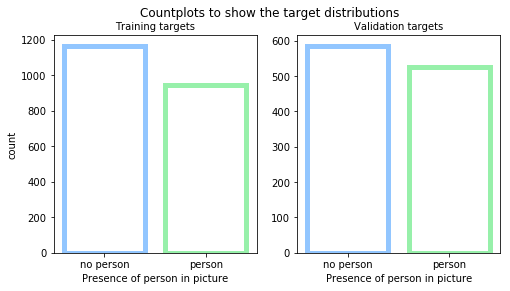

In [81]:
#Have a look at target distributions of training and validation sets
#Creating a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
plt.suptitle("Countplots to show the target distributions\n")

#Training set subplot
sns.countplot(y_tr_B, ax=ax1, facecolor=(0, 0, 0, 0), linewidth=5, edgecolor=sns.color_palette("pastel"))
ax1.set_title("Training targets", size=10)
ax1.set_xlabel("Presence of person in picture")
plt.setp(ax1, xticklabels=["no person", "person"])

#Validation set subplot
sns.countplot(y_val_B, ax=ax2, facecolor=(0, 0, 0, 0), linewidth=5, edgecolor=sns.color_palette("pastel"))
ax2.set_title("Validation targets", size=10)
ax2.set_xlabel("Presence of person in picture")
ax2.set_ylabel("")
plt.setp(ax2, xticklabels=["no person", "person"])

plt.show()

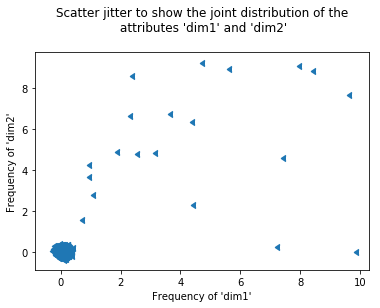

In [82]:
#Investigate whether there is any need to preprocess data in terms of outliers
def scatter_jitter(arr1, arr2, jitter=0.2):
    """ Plots a joint scatter plot of two arrays by adding small noise to each example. 
    Noise is proportional to variance in each dimension. """
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    arr1 = arr1 + jitter*arr1.std(axis=0)*np.random.standard_normal(arr1.shape)
    arr2 = arr2 + jitter*arr2.std(axis=0)*np.random.standard_normal(arr2.shape)
    plt.scatter(arr1, arr2, marker=4)
    
#Plot scatter jitter to look at relationship between two features and if there are any outliers
plt.title("Scatter jitter to show the joint distribution of the\n attributes 'dim1' and 'dim2'\n")
plt.xlabel("Frequency of 'dim1'")
plt.ylabel("Frequency of 'dim2'")
scatter_jitter(train_B["dim1"], train_B["dim2"], jitter=0.2)

I see that it doesn't seem to be worth eliminating outliers as there aren't any values that seem expecially unreasonable. 

## Fitting a dummy classifier before preprocessing

In [83]:
dummy = DummyClassifier(random_state=0)
dummy.fit(X_tr_B, y_tr_B)
print(log_loss(y_tr_B, dummy.predict_proba(X_tr_B)))

#priot one use
print(log_loss(y_val_B, dummy.predict_proba(X_val_B)))
#logprint("The log loss of my dummy classifier on the training data before preprocessing is {} and on my validation data is {}".format(log_loss(y_tr_B, dummy.predict(X_tr_B)), log_loss(y_val_B, dummy.predict(X_val_B))))

17.6698614685
16.9125185402


## Preprocessing

### Preprocessing using standard scaling

In [84]:
scaled = StandardScaler()
scaled.fit(X_tr_B)
scaled_X_tr_B=(scaled.transform(X_tr_B))
scaled_X_val_B=(scaled.transform(X_val_B))
scaled_X_test_B=(scaled.transform(X_test_B))

### Fitting a dummy classifier after preprocessing

In [85]:
dummy2 = DummyClassifier(random_state=0)
dummy2.fit(scaled_X_tr_B, y_tr_B)
print("The log loss of my dummy classifier on the training data after preprocessing is {} and on my validation data is {}".format(log_loss(y_tr_B, dummy2.predict_proba(scaled_X_tr_B)), log_loss(y_val_B, dummy2.predict_proba(scaled_X_val_B))))

The log loss of my dummy classifier on the training data after preprocessing is 17.6698614685 and on my validation data is 16.9125185402


## Training and Evaluating different model classifiers after preprocessing

#### I have more than 50 samples, I'm predicting a category I have labelled data and I have less than 100K samples: try Linear SVC

In [86]:
# store values in arrays to use in ensemble model later, and to plot graphs
estimators = []
models_used = []
models_log_losses_tr = []
models_log_losses_val = []

In [ ]:
linearSVC = LinearSVC()
clf = CalibratedClassifierCV(linearSVC) 
clf.fit(scaled_X_tr_B, y_tr_B)

linearSVC_log_loss_tr = log_loss(y_tr_B, clf.predict_proba(scaled_X_tr_B))
linearSVC_log_loss_val = log_loss(y_val_B, clf.predict_proba(scaled_X_val_B))

print("Model: {}\n\nLog loss:\n\nTraining data: {}\nValidation data: {}".format('linearSVC', linearSVC_log_loss_tr, linearSVC_log_loss_val))

In [ ]:
estimators.append(('SVClinear', clf))
models_used.append('linear')
models_log_losses_tr.append(linearSVC_log_loss_tr)
models_log_losses_val.append(linearSVC_log_loss_val)

In [ ]:
solverScoresTr = []
solverScoresVal=[]
solvers = ['newton-cg', 'lbfgs', 'liblinear']
for solver in solvers:
    logisticCV2 = LogisticRegressionCV(Cs=C, cv=kfold, solver=solver)
    logisticCV2.fit(scaled_X_tr_B, y_tr_B)
    solverScoresTr.append(log_loss(y_tr_B, logisticCV2.predict_proba(scaled_X_tr_B)))
    solverScoresVal.append(log_loss(y_val_B, logisticCV2.predict_proba(scaled_X_val_B)))

In [ ]:
print("Model: {}\n\nLog loss:\n\nTraining data:\nwith solver {} : {} \nwith solver {}: {} \nwith solver {}: {}\n\nValidation data: \nwith solver {}: {}\nwith solver {} : {} \nwith solver {} : {}".format('Logistic', solvers[0], solverScoresTr[0], solvers[1], solverScoresTr[1], solvers[2], solverScoresTr[2], solvers[0], solverScoresVal[0], solvers[1], solverScoresVal[1], solvers[2], solverScoresVal[2]))

In [ ]:
plt.scatter([0,1,2], solverScoresTr, label='training dataset')
plt.scatter([0,1,2], solverScoresVal, label= 'validation dataset')
plt.legend()
plt.xticks([0,1,2])
plt.xlabel("Solver")
plt.xticks(range(3), solvers)
plt.ylabel("Log loss")
plt.title('Plot to show the different solver setting in logistic model against the log losses')

plt.show()

From this graph and the printed out accuracy values, I would say that lbfgs is the best solver to use because it has the lowest log loss on the validation dataset and also it has the lowest discrepency between training and validation set log losses.

In [ ]:
#initialise logistic with solver that I chose
logistic = LogisticRegressionCV(Cs=C, cv=kfold, solver='lbfgs')
logistic.fit(scaled_X_tr_B, y_tr_B)

logistic_log_loss_tr = log_loss(y_tr_B, logistic.predict_proba(scaled_X_tr_B))
logistic_log_loss_val = log_loss(y_val_B, logistic.predict_proba(scaled_X_val_B))

print("Model: {}\n\nLog loss:\n\nTraining data: {}\nValidation data: {}".format('logistic', logistic_log_loss_tr, logistic_log_loss_val))

In [ ]:
estimators.append(('logistic', logistic))
models_used.append('logistic')
models_log_losses_tr.append(logistic_log_loss_tr)
models_log_losses_val.append(logistic_log_loss_val)

#### I don't have text data: try K Neighbours classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_log_loss_training = []
n_log_loss_validation = []

n=np.arange(30)

for index, neighbours in enumerate(n):
    KNN = KNeighborsClassifier(n_neighbors=index+1)
    KNN.fit(scaled_X_tr_B, y_tr_B)
    KNN_log_loss_tr = log_loss(y_tr_B, KNN.predict_proba(scaled_X_tr_B))
    n_log_loss_training.append(KNN_log_loss_tr)
    KNN_log_loss_val = log_loss(y_val_B, KNN.predict_proba(scaled_X_val_B))
    n_log_loss_validation.append(KNN_log_loss_val)

In [ ]:
plt.plot(n, n_log_loss_training, label='log loss on training data')
plt.plot(n, n_log_loss_validation, label='log loss on validation data')
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Log loss')
plt.title('Plot to show the log losses on the training and validations data \nusing a different number of nearest neighbours')
plt.legend()
plt.show()

In [ ]:
plt.plot(n, n_log_loss_training, label='log loss on training data')

plt.plot(n, n_log_loss_validation, label='log loss on validation data')

plt.xlabel('Number of nearest neighbours')

plt.xlim([15,30])
plt.ylim([0,1])

plt.ylabel('Log loss')

plt.title('Plot to show the log losses on the trianing and validations data \nusing a different number of nearest neighbours')

plt.legend()

plt.show()

By eyeing the graphs, I see that with very few nearest neighbours, the algorithm overfits to the training data. I can see that as there is a large discrepency between the log loss on the training data and the log loss on the validation data. At Around 19 nearest neighbours, there is little overfitting and the log loss seems to flatten out after that, so there is no point having any more neighbours than thsi as this would just be more computationally expensive for no improvement.

In [ ]:
#Initialise KNN using number of n that I chose
KNN = KNeighborsClassifier(n_neighbors=19)
KNN.fit(scaled_X_tr_B, y_tr_B)

KNN_log_loss_tr = log_loss(y_tr_B, KNN.predict_proba(scaled_X_tr_B))
KNN_log_loss_val = log_loss(y_val_B, KNN.predict_proba(scaled_X_val_B))

print("Model: {}\n\nLog loss:\n\nTraining data: {}\nValidation data: {}".format('K Neighbours', KNN_log_loss_tr, KNN_log_loss_val))

In [ ]:
estimators.append(('KNN', KNN))
models_used.append('K Nearest Neighbours')
models_log_losses_tr.append(KNN_log_loss_tr)
models_log_losses_val.append(KNN_log_loss_val)

#### Try support vector machine classifiers

In [ ]:
svc_linear = SVC(kernel='linear', random_state=0, probability=True)
svc_linear.fit(scaled_X_tr_B, y_tr_B)

svc_linear_log_loss_tr = log_loss(y_tr_B, svc_linear.predict_proba(scaled_X_tr_B))
svc_linear_log_loss_val = log_loss(y_val_B, svc_linear.predict_proba(scaled_X_val_B))

print("Model: {}\n\nLog loss:\n\nTraining data: {}\nValidation data: {}".format('SVC with linear kernel', svc_linear_log_loss_tr, svc_linear_log_loss_val))

In [ ]:
estimators.append(('SVClinearKernel', svc_linear))
models_used.append('SVClinearKernel')
models_log_losses_tr.append(svc_linear_log_loss_tr)
models_log_losses_val.append(svc_linear_log_loss_val)

In [ ]:
svc_rbf = SVC(kernel='rbf', random_state=0, probability=True)
svc_rbf.fit(scaled_X_tr_B, y_tr_B)

svc_rbf_log_loss_tr = log_loss(y_tr_B, svc_rbf.predict_proba(scaled_X_tr_B))
svc_rbf_log_loss_val = log_loss(y_val_B, svc_rbf.predict_proba(scaled_X_val_B))

print("Model: {}\n\nLog loss:\n\nTraining data: {}\nValidation data: {}".format('SVC with rbf kernel', svc_rbf_log_loss_tr, svc_rbf_log_loss_val))

In [ ]:
estimators.append(('SVCrbfKernel', svc_rbf))
models_used.append('SVCrbfKernel')
models_log_losses_tr.append(svc_rbf_log_loss_tr)
models_log_losses_val.append(svc_rbf_log_loss_val)

In [ ]:
svc_poly = SVC(kernel='poly', random_state=0, probability=True)
svc_poly.fit(scaled_X_tr_B, y_tr_B)

svc_poly_log_loss_tr = log_loss(y_tr_B, svc_poly.predict_proba(scaled_X_tr_B))
svc_poly_log_loss_val = log_loss(y_val_B, svc_poly.predict_proba(scaled_X_val_B))

print("Model: {}\n\nLog loss:\n\nTraining data: {}\nValidation data: {}".format('SVC with polynomial kernel', svc_rbf_log_loss_tr, svc_rbf_log_loss_val))

In [ ]:
estimators.append(('SVCpolyKernel', svc_poly))
models_used.append('SVCpolyKernel')
models_log_losses_tr.append(svc_poly_log_loss_tr)
models_log_losses_val.append(svc_poly_log_loss_val)

#### Try ensemble classifiers

In [ ]:
from sklearn.ensemble import RandomForestClassifier

depth = np.arange(30)
depths_log_loss_tr = []
depths_log_loss_val = []

for index, depths in enumerate(depth):
    RF = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=index+1)
    RF.fit(scaled_X_tr_B, y_tr_B)
    RF_log_loss_tr = log_loss(y_tr_B, RF.predict_proba(scaled_X_tr_B))
    RF_log_loss_val = log_loss(y_val_B, RF.predict_proba(scaled_X_val_B))
    depths_log_loss_tr.append(RF_log_loss_tr)
    depths_log_loss_val.append(RF_log_loss_val)

In [ ]:
plt.plot(depth, depths_log_loss_tr, label='training data')
plt.plot(depth, depths_log_loss_val, label='validation data')
plt.xlabel('Max depth')
plt.ylabel('Log loss')
plt.legend()
plt.title('Plot to show max depth in random forest against log loss scores')
plt.show()

I can see from this graph that although the log loss is good for the validation set with a random forest classifier, the discrepency between the losses for the training and validation sets is very large, so it is overfitting to the training data. Discussed further in report. 

In [90]:
RF1 = RandomForestClassifier(n_estimators=500, random_state=0)
RF1.fit(scaled_X_tr_B, y_tr_B)
#RF_log_loss_tr = log_loss(y_tr_B, RF.predict_proba(scaled_X_tr_B))
#RF_log_loss_val = log_loss(y_val_B, RF.predict_proba(scaled_X_val_B))

#print("Model: {}\n\nLog loss:\n\nTraining data: {}\nValidation data: {}".format('Random forest', RF_log_loss_tr, RF_log_loss_val))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
estimators.append(('RBF', RF))
models_used.append('RBF')
models_log_losses_tr.append(RF_log_loss_tr)
models_log_losses_val.append(RF_log_loss_val)

In [ ]:
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(scaled_X_tr_B, y_tr_B)
ensembleVotingClassifier_log_loss_tr = log_loss(y_tr_B, ensemble.predict_proba(scaled_X_tr_B))
ensembleVotingClassifier_log_loss_val = log_loss(y_val_B, ensemble.predict_proba(scaled_X_val_B))

In [ ]:
ensembleVotingClassifier_log_loss_tr

In [ ]:
ensembleVotingClassifier_log_loss_val

In [ ]:
models_used.append('Ensemble voting classifier')
models_log_losses_tr.append(ensembleVotingClassifier_log_loss_tr)
models_log_losses_val.append(ensembleVotingClassifier_log_loss_val)

In [ ]:
plt.figure(figsize=(8,4))
x=np.arange(len(models_used))
plt.plot(x, models_log_losses_tr)
plt.plot(x, models_log_losses_val)
plt.xlabel('Model')
plt.ylabel('log loss')
plt.xticks(range(8), models_used, rotation=70)
plt.title('Plot showing the different models trained against the log losses they produced')
plt.show()

## Try a different preprocessing technique: PCA

In [ ]:
from sklearn.decomposition import PCA
#Create new PCA object and fit with data
pcaB = PCA(n_components=X_tr_B.shape[1])
pcaB.fit(X_tr_B)

#Find the first index where the cumulative explained ration is larger than 0.95
#Add 1 to the index to find the x value (number of components) because indexing starts from
#0 but number of components starts from 1
xNinetyFive = np.where(pcaB.explained_variance_ratio_.cumsum()>0.95)[0][0]+1

#Plot explained variance ration against number of components
plt.plot(pcaB.explained_variance_ratio_, color = 'm')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('Plot showing explained variance ration against number of components')
plt.vlines(xNinetyFive, 0, 1, color = 'c', linestyles='dotted')
plt.annotate(str(xNinetyFive) + " eigenvectors are used \nwhen 95% of the variance\n has been explained ", xytext=(35, 0.08), xy=(xNinetyFive,pcaB.explained_variance_ratio_[xNinetyFive]),arrowprops=dict(arrowstyle="fancy", connectionstyle="arc3"))
plt.show()

#Plot cumulative explained variance ration against number of components
plt.plot(pcaB.explained_variance_ratio_.cumsum(), color = 'm')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('Plot showing cumulative explained variance ration against number of components')
plt.hlines(0.95, 0, 500, color = 'c', linestyles='dotted')
plt.show()

In [ ]:
pca2 = PCA(n_components=xNinetyFive)
pca2.fit(X_tr_B)
transformedDataTrain = pcaB.transform(X_tr_B)
transformedDataVal=pcaB.transform(X_val_B)

## Repeat the same process fitting models, but with PCA transformed data

#### Try the previously best performing models with new PCA features

In [ ]:
linearSVC = LinearSVC()
clf = CalibratedClassifierCV(linearSVC) 
clf.fit(transformedDataTrain, y_tr_B)

print("Model: {}\nLog loss:\nTraining data: {}\nValidation data: {}".format('linearSVC', log_loss(y_tr_B, clf.predict_proba(transformedDataTrain)),log_loss(y_val_B, clf.predict_proba(transformedDataVal))))

In [89]:
RF = RandomForestClassifier(n_estimators=500, random_state=0)
RF.fit(transformedDataTrain, y_tr_B)
#RF_log_loss_tr = log_loss(y_tr_B, RF.predict_proba(transformedDataTrain))
#RF_log_loss_val = log_loss(y_val_B, RF.predict_proba(transformedDataVal))

#print("Model: {}\n\nLog loss:\n\nTraining data: {}\nValidation data: {}".format('Random forest', RF_log_loss_tr, RF_log_loss_val))

NameError: name 'transformedDataTrain' is not defined

# Report

I am trying to find the best classifier for the person/no person classification task To do this, I first investigated my data a little to get a feel for it and dropped the class and imgID columns from the training and validation datasets, as we wouldn't have these for new unseen data. I decided there was no need to remove outliers since there were no obviously extreme ones. I then fit a dummy classifier even before preprocessing to get an absolute baseline. I next preprocessed the training and validation data by using standard scaling to change all the training feature means to 0 and standard deviations to 1 and then fit the validation to this, so that my classifiers would yield better results. I then fit a dummy classifier after preprocessing too. 

To start my investigation with classifiers, I looked at http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html and followed this to have an idea of where to begin my investigation. I had more than 50 data samples, I was predicting a person/no person category, I had labelled data and I had less than 100K samples. Therefore, I began my investigation with a linear SVC. This had a fairly good log loss of ~0.693 on the validation set. In fact, most of the classifiers ended up with losses around 0.6-0.7. I then thought, because we are dealing with categorical data, that I would try and fit a logistic model. I tried three different solvers (I did not try sag and saga since they were too computationally expensive). I plotted a scatter plot of the log losses with each solver and decided that lbfgs was the best as it obtained the lowest validation score and also over fitted to the training data the least. 

Since I don't have text data, I next tried K Neighbours classifier. I plotted a graph of the number of nearest neighbours used against the log loss, and chose 19 as a suitable number as it yielded a low log loss and also did not overfit too much to the training data. 

I then tried support vector machine models with each of the kernels. Again, I got values in the range 0.6-0.7 for the log losses. 

I then tried ensemble classifiers. I first tried a random forest classifier, and varied the max depth to find a suitable one. I saw from this graph that although the log loss was good for the validation set with a random forest classifier, the discrepancy between the losses for the training and validation sets was very large, so it was over fitting to the training data. If we didn't have a validation set, then this would be important, however we do and so the log loss on the validation accuracy is a good indicator of how well the model performs on unseen data. Random forest gave me the best validation log loss so far (0.585005399772).

Next I trained a voting classifier model to see if the models better would yield a better result. I added each model to an estimators array as I was going though the challenge so that I could create a new model of them together. This ensemble model performed reasonably well with a log loss of   on the validation 0.6283422692061178, however it was not as good as random forest by itself (although it did overfit a lot less!).

I plotted a graph of each of the models I investigated against the log losses they achieved on both datasets so I could more easily compare them. 

I then tried a different preprocessing technique since the features can be more important that the model. I used PCA with 95% explained variance. However, on my best two models (logistic and random forest), it performed worse.

In the end, I decided to use standard scaling and the random forest with no maximum depth as a model as it gave me the best log loss score on the validation data. 

If I were to do a further investigation, I would explore some more different preprocessing techniques and also do further tuning to find optimal parameters (such as finding optimal C , degree and gamma for SVM classifiers – although this can be very computationally expensive). 

In [91]:
test_images_partB_pred_proba = RF1.predict_proba(X_test_B)

In [92]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array is not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

# You need to replace "test_images_partB_pred_proba"
# with the name of the array which contains the probability 
# estimates for the data in the test set.
save_predictions(test_images_partB_pred_proba) 

# Appendix

## More information about visual words

Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image)